In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

# BEFORE YOU RUN
## Required Project Structure
To ensure that all notebooks and scripts run correctly, please maintain the following structure at the **project root**. Note that the `data/` folder must be at the same level as the `notebooks/` and `src/` folders.

```text
.
├── api/                                  # FastAPI/Flask code
├── data/                                 # [IGNORED BY GIT - LOCAL ONLY]
│   ├── cyber_dataset/
│   │   ├── auth.txt.gz                   # Authentication logs (Large)
│   │   └── redteam.txt.gz                # Redteam labels
│   ├── elliptic_bitcoin_dataset/
│   │   ├── elliptic_txs_classes.csv
│   │   ├── elliptic_txs_edgelist.csv
│   │   └── elliptic_txs_features.csv
│   └── keystroke_dynamics_dataset/
│       └── DSL-StrongPasswordData.csv
├── notebooks/
│   └── EDA.ipynb                         # Current Notebook
├── src/                                  # Source code for training/API
├── vis/                                  # Visualization assets
├── .gitignore
├── README.md
└── requirements.txt

In [3]:
# Read in the Datasets
df_labels = pd.read_csv('../data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv') # maps transaction IDs to licit, illicit, unknown
df_edges = pd.read_csv('../data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv') # the adjacency list [who sent money to who]
df_features = pd.read_csv('../data/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None) # 166 features for each transaction

# Rename the first two columns based on dataset documentation
df_features.columns = ['txId', 'time_step'] + [f'feat_{i}' for i in range(1, 166)]

# Merge labels into features
df_full = pd.merge(df_features, df_labels, on='txId')

# Introduction to the Elliptic Bitcoin Dataset

The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph.

## Content

This anonymized data set is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.

## Nodes and Edges

The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.

## Features

There are 166 features associated with each node. Due to intellectual property issues, we cannot provide an exact description of all the features in the dataset. There is a time step associated to each node, representing a measure of the time when a transaction was broadcasted to the Bitcoin network. The time steps, running from 1 to 49, are evenly spaced with an interval of about two weeks. Each time step contains a single connected component of transactions that appeared on the blockchain within less than three hours between each other; there are no edges connecting the different time steps.

The first 94 features represent local information about the transaction – including the time step described above, number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average number of incoming (outgoing) transactions associated with the inputs/outputs. The remaining 72 features are aggregated features, obtained using transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and correlation coefficients of the neighbour transactions for the same information data (number of inputs/outputs, transaction fee, etc.).

# Class Distribution & Imbalance
Visualise labels for nodes (2% illicit, 21% licit, 77% unknown)

Class Distribution:
class
unknown    157205
2           42019
1            4545
Name: count, dtype: int64


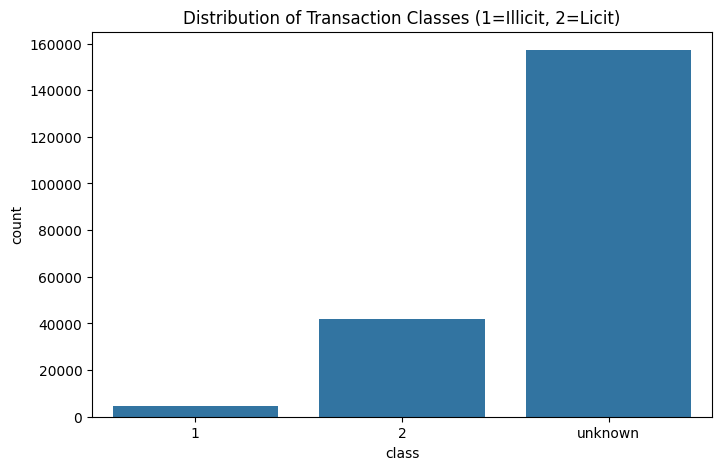

In [4]:
# Map classes for readability: 1=illicit, 2=licit, unknown=unknown
class_counts = df_full['class'].value_counts()
print(f"Class Distribution:\n{class_counts}")

plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df_full, order=['1', '2', 'unknown'])
plt.title('Distribution of Transaction Classes (1=Illicit, 2=Licit)')
plt.show()

# Temporal Analysis 
Analyse data over time period of 49 snapshots to identify patterns in fraud.

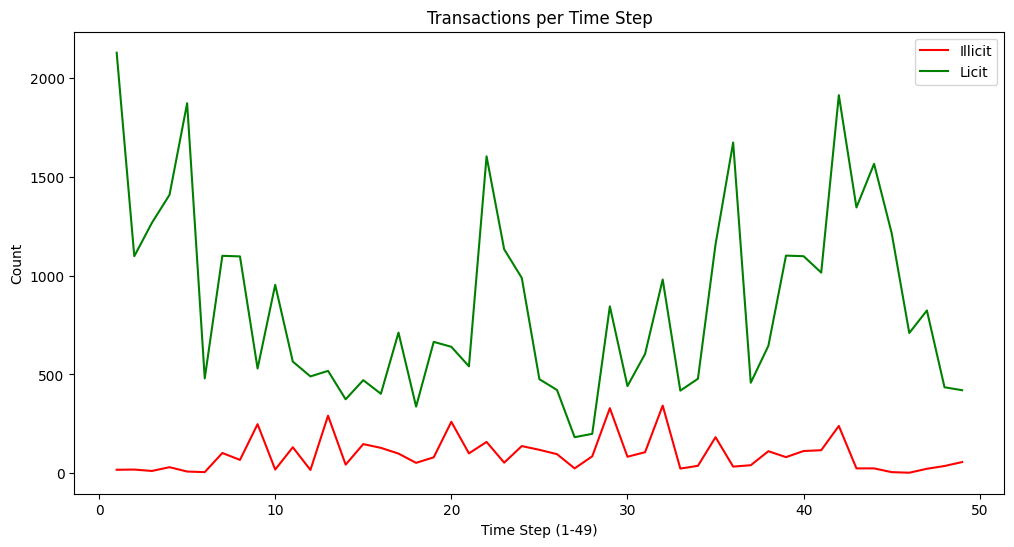

In [5]:
# Count illicit (class 1) transactions per time step
illicit_per_step = df_full[df_full['class'] == '1'].groupby('time_step').size()
licit_per_step = df_full[df_full['class'] == '2'].groupby('time_step').size()

plt.figure(figsize=(12, 6))
plt.plot(illicit_per_step.index, illicit_per_step.values, label='Illicit', color='red')
plt.plot(licit_per_step.index, licit_per_step.values, label='Licit', color='green')
plt.title('Transactions per Time Step')
plt.xlabel('Time Step (1-49)')
plt.ylabel('Count')
plt.legend()
plt.show()

# Graph Structure Analysis
Use NetworkX to analyse connectivity (degree distribution)

Number of illicit-to-illicit edges: 998


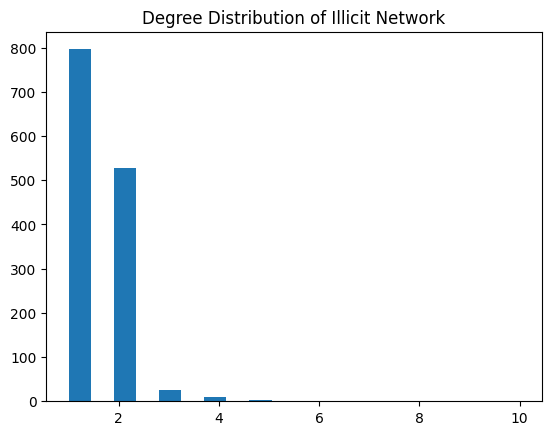

In [7]:
# Create a sample graph of the illicit transactions to find fraud rings
illicit_ids = df_full[df_full['class'] == '1']['txId'].values
df_illicit_edges = df_edges[df_edges['txId1'].isin(illicit_ids) & df_edges['txId2'].isin(illicit_ids)]

G_illicit = nx.from_pandas_edgelist(df_illicit_edges, 'txId1', 'txId2')
print(f"Number of illicit-to-illicit edges: {G_illicit.number_of_edges()}")

# Plot degree distribution
degrees = [d for n, d in G_illicit.degree()]
plt.hist(degrees, bins=20)
plt.title('Degree Distribution of Illicit Network')
plt.show()

# Time-based split
Remove "unknown" nodes to train supervised model. Train on earlier time steps and test on later ones to mimick real life deployment (predict future fraud from past patterns).

In [9]:
# Filter out 'unknown' for the baseline model
df_baseline = df_full[df_full['class'] != 'unknown'].copy()
df_baseline['class'] = df_baseline['class'].map({'1': 1, '2': 0}) # 1=Fraud, 0=Not Fraud

# Temporal Split: Train on first 39 steps, Test on remaining 10
train_data = df_baseline[df_baseline['time_step'] <= 39]
test_data = df_baseline[df_baseline['time_step'] > 39]

X_train = train_data.drop(['txId', 'class', 'time_step'], axis=1)
y_train = train_data['class']
X_test = test_data.drop(['txId', 'class', 'time_step'], axis=1)
y_test = test_data['class']

print(f"Training shapes: {X_train.shape}, Test shapes: {X_test.shape}")

Training shapes: (35380, 165), Test shapes: (11184, 165)


# Training baseline model as benchmark
In this section, an XGBoost model is trained to establish a "non-graph" benchmark model for the bitcoin dataset.

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, precision_recall_curve,
                             average_precision_score, f1_score,
                             precision_score, recall_score)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ── 1. Class Imbalance: scale_pos_weight = #licit / #illicit ──────────────────
neg_count = (y_train == 0).sum()   # licit
pos_count = (y_train == 1).sum()   # illicit
scale_pos_weight = neg_count / pos_count
print(f"Train  →  illicit: {pos_count}  |  licit: {neg_count}")
print(f"scale_pos_weight = {scale_pos_weight:.2f}  (auto-compensates for imbalance)\n")

# ── 2. Train XGBoost ──────────────────────────────────────────────────────────
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False)
print("XGBoost training complete.\n")

# ── 3. Predictions & threshold-based metrics ──────────────────────────────────
y_prob  = xgb.predict_proba(X_test)[:, 1]
y_pred  = xgb.predict(X_test)

precision_val = precision_score(y_test, y_pred)
recall_val    = recall_score(y_test, y_pred)
f1_val        = f1_score(y_test, y_pred)
auprc_val     = average_precision_score(y_test, y_prob)

print(classification_report(y_test, y_pred, target_names=['Licit (0)', 'Illicit (1)']))
print(f"AUPRC : {auprc_val:.4f}")

# ── 4. Feature Importance: Local (feat_1–93) vs Aggregated (feat_94–165) ──────
# X_train columns are feat_1 … feat_165 (time_step already dropped).
# local features      = feat_1  … feat_93   (93 transactional features)
# aggregated features = feat_94 … feat_165  (72 1-hop neighbourhood features)
feature_names = X_train.columns.tolist()
importances   = xgb.feature_importances_

local_mask = np.array([int(f.split('_')[1]) <= 93 for f in feature_names])
agg_mask   = ~local_mask

local_importance = importances[local_mask].sum()
agg_importance   = importances[agg_mask].sum()
total            = local_importance + agg_importance

print(f"\nFeature Group Importance")
print(f"  Local (feat_1–93)        : {local_importance:.4f}  ({100*local_importance/total:.1f}%)")
print(f"  Aggregated (feat_94–165) : {agg_importance:.4f}  ({100*agg_importance/total:.1f}%)")
if agg_importance > local_importance:
    print("  → Aggregated features dominate: network context is crucial for fraud detection.")
else:
    print("  → Local features dominate: transaction-level signals drive the model.")


Train  →  illicit: 3909  |  licit: 31471
scale_pos_weight = 8.05  (auto-compensates for imbalance)

XGBoost training complete.

              precision    recall  f1-score   support

   Licit (0)       0.98      0.99      0.99     10548
 Illicit (1)       0.88      0.63      0.74       636

    accuracy                           0.97     11184
   macro avg       0.93      0.81      0.86     11184
weighted avg       0.97      0.97      0.97     11184

AUPRC : 0.7745

Feature Group Importance
  Local (feat_1–93)        : 0.7500  (75.0%)
  Aggregated (feat_94–165) : 0.2500  (25.0%)
  → Local features dominate: transaction-level signals drive the model.


In [ ]:
# ── 5a. Bar chart: Local vs Aggregated importance ─────────────────────────────
fig1, ax1 = plt.subplots(figsize=(6, 5))
groups  = ['Local\n(feat 1–93)', 'Aggregated\n(feat 94–165)']
vals    = [local_importance, agg_importance]
colours = ['steelblue', 'tomato']
bars    = ax1.bar(groups, vals, color=colours, edgecolor='black', width=0.45)
ax1.bar_label(bars, labels=[f'{v:.3f}\n({100*v/total:.1f}%)' for v in vals], padding=4)
ax1.set_title('Feature Group Importance\n(Local vs Aggregated)', fontsize=12)
ax1.set_ylabel('Summed Feature Importance')
ax1.set_ylim(0, max(vals) * 1.25)
plt.tight_layout()
plt.savefig('../vis/xgb_feature_group_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# ── 5b. Top-20 individual feature importances ─────────────────────────────────
fig2, ax2 = plt.subplots(figsize=(10, 7))
top20_idx   = np.argsort(importances)[::-1][:20]
top20_names = [feature_names[i] for i in top20_idx]
top20_imp   = importances[top20_idx]
top20_cols  = ['tomato' if int(n.split('_')[1]) > 93 else 'steelblue' for n in top20_names]
ax2.barh(top20_names[::-1], top20_imp[::-1], color=top20_cols[::-1], edgecolor='black')
ax2.set_title('Top-20 Feature Importances\n(blue = local, red = aggregated)', fontsize=12)
ax2.set_xlabel('Importance Score')
plt.tight_layout()
plt.savefig('../vis/xgb_top20_features.png', dpi=150, bbox_inches='tight')
plt.show()

# ── 5c. Precision–Recall Curve (AUPRC) ───────────────────────────────────────
fig3, ax3 = plt.subplots(figsize=(8, 6))
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
ax3.plot(rec, prec, color='darkorange', lw=2,
         label=f'PR Curve (AUPRC = {auprc_val:.3f})')
ax3.scatter([recall_val], [precision_val], s=120, zorder=5,
            color='red', label=f'Default threshold  P={precision_val:.2f}  R={recall_val:.2f}')
ax3.axhline(y=pos_count / (pos_count + neg_count), color='navy', linestyle='--',
            lw=1.2, label='Random classifier baseline')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision–Recall Curve', fontsize=12)
ax3.legend(fontsize=9)
ax3.set_xlim([0, 1]); ax3.set_ylim([0, 1.02])
plt.tight_layout()
plt.savefig('../vis/xgb_pr_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# ── 5d. Performance metrics bar chart ────────────────────────────────────────
fig4, ax4 = plt.subplots(figsize=(6, 5))
metric_names  = ['Precision', 'Recall', 'F1-Score', 'AUPRC']
metric_values = [precision_val, recall_val, f1_val, auprc_val]
bar_colours   = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']
b = ax4.bar(metric_names, metric_values, color=bar_colours, edgecolor='black', width=0.5)
ax4.bar_label(b, labels=[f'{v:.3f}' for v in metric_values], padding=4)
ax4.set_ylim(0, 1.15)
ax4.set_title('Model Performance Metrics\n(Illicit class)', fontsize=12)
ax4.set_ylabel('Score')
ax4.tick_params(axis='x', rotation=15)
plt.tight_layout()
plt.savefig('../vis/xgb_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figures saved to vis/")
